In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import time
import matplotlib.animation as animation

from copy import deepcopy
from IPython.display import display, clear_output
from noise import pnoise2
from stable_fluid.fluid import Fluid
from matplotlib.collections import LineCollection
#z, y, x순서임.

#근데 speed[0]은 x벡터의 크기, speed[1]은 y벡터의 크, speed[2]는 z벡터의 크기 됨 주의.
RESOLUTION = 297, 210
DT = 0.3 #simulation sparsity.
FRAME_DT = 10
TOTAL_T = 1009

INFLOW_DURATION = 3000
INFLOW_TEMPERTURE = 0.1

num_polyline = 100
num_points = 2500

buoyancy_a = 0.1

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device: ", device)

fluid = Fluid(RESOLUTION, 'dye', 'heat', device = device)

middle = int(RESOLUTION[1] / 2)
offset = 10

inflow_heat = torch.zeros(fluid.shape, device=device)
inflow_heat[6, middle-offset:middle+offset] += INFLOW_TEMPERTURE

inflow_dye = torch.zeros(fluid.shape, device=device)
inflow_dye[6, middle-offset:middle+offset] = 0.8

device:  cuda


In [3]:
def advect_polylines(vector_field: torch.Tensor, polylines: torch.Tensor, dt: float) -> torch.Tensor:
    """
    vector_field: (2, ny, nx), vector_field[0] = u, vector_field[1] = v
    polylines: (num_polylines, num_points, 2)
    dt: float
    return: (num_polylines, num_points, 2), 좌표는 제한 없이 계속 확장됨
    """
    if polylines.numel() == 0:
        return polylines

    ny, nx = vector_field.shape[1], vector_field.shape[2]

    # 좌표 분리
    x = polylines[..., 0]  # (num_polylines, num_points)
    y = polylines[..., 1]

    # 속도 구할 때만 periodic index 적용
    x0 = torch.floor(x).long() % nx
    y0 = torch.floor(y).long() % ny
    x1 = (x0 + 1) % nx
    y1 = (y0 + 1) % ny

    sx = x - torch.floor(x)
    sy = y - torch.floor(y)

    # bilinear interpolation (배치 연산)
    u = (1 - sx) * (1 - sy) * vector_field[0, y0, x0] + \
        sx * (1 - sy) * vector_field[0, y0, x1] + \
        (1 - sx) * sy * vector_field[0, y1, x0] + \
        sx * sy * vector_field[0, y1, x1]

    v = (1 - sx) * (1 - sy) * vector_field[1, y0, x0] + \
        sx * (1 - sy) * vector_field[1, y0, x1] + \
        (1 - sx) * sy * vector_field[1, y1, x0] + \
        sx * sy * vector_field[1, y1, x1]

    # 좌표는 제한하지 않고 이동
    new_x = x + u * dt
    new_y = y + v * dt

    return torch.stack([new_x, new_y], dim=-1)


In [4]:
def redistribute_polyline_points(polylines: torch.Tensor) -> torch.Tensor:
    """
    polylines: (num_polylines, num_points, 2)
    return: (num_polylines, num_points, 2)
    
    각 polyline의 점 수를 유지하면서 점들의 위치를 일정 간격으로 재조정.
    """
    num_polylines, num_points, _ = polylines.shape
    device = polylines.device

    # segment 길이
    diffs = polylines[:, 1:, :] - polylines[:, :-1, :]  # (B, N-1, 2)
    dists = torch.linalg.norm(diffs, dim=2)  # (B, N-1)

    # 누적 아크 길이'
    cumdist = torch.cat([torch.zeros((num_polylines,1), device=device), torch.cumsum(dists, dim=1)], dim=1)  # (B, N)

    total_len = cumdist[:, -1:]  # (B, 1)
    # 새로운 점들의 위치 (등간격)
    new_pos = torch.linspace(0, 1, num_points, device=device).unsqueeze(0) * total_len  # (B, N)

    # 각 new_pos가 속한 segment 찾기
    idx = torch.searchsorted(cumdist, new_pos, right=True) - 1
    idx = torch.clamp(idx, 0, num_points-2)

    seg_start = torch.gather(polylines, 1, idx.unsqueeze(-1).expand(-1,-1,2))
    seg_vec = torch.gather(diffs, 1, idx.unsqueeze(-1).expand(-1,-1,2))
    seg_len = torch.gather(dists, 1, idx)

    seg_offset = new_pos - torch.gather(cumdist, 1, idx)
    ratio = (seg_offset / (seg_len + 1e-8)).unsqueeze(-1)

    resampled = seg_start + seg_vec * ratio
    return resampled



In [5]:
def get_drawing_polylines(polylines):
    
    drawing_polylines = []
    res_tensor = torch.tensor(RESOLUTION[::-1])  # (W,H) → 텐서로 변환
    for poly in polylines:
        polyline = []
        prev_div = None  # 이전 점이 속한 cell 기록
        
        for point in poly:
            point = point.cpu()
            
            # (x,y) 좌표 → 어떤 cell인지 계산
            div = (point // res_tensor).tolist()
            
            # polyline이 끊어져야 하는 경우
            if prev_div is not None and div != prev_div:
                if polyline:  # 지금까지 모인 점 저장
                    drawing_polylines.append(polyline)
                polyline = []
            
            # 현재 cell 내부 좌표 (잔여 좌표)
            local_point = (point % res_tensor).tolist()
            polyline.append(local_point)
            
            prev_div = div
        
        if polyline:  # 마지막 잔여 선분 처리
            drawing_polylines.append(polyline)
    return drawing_polylines

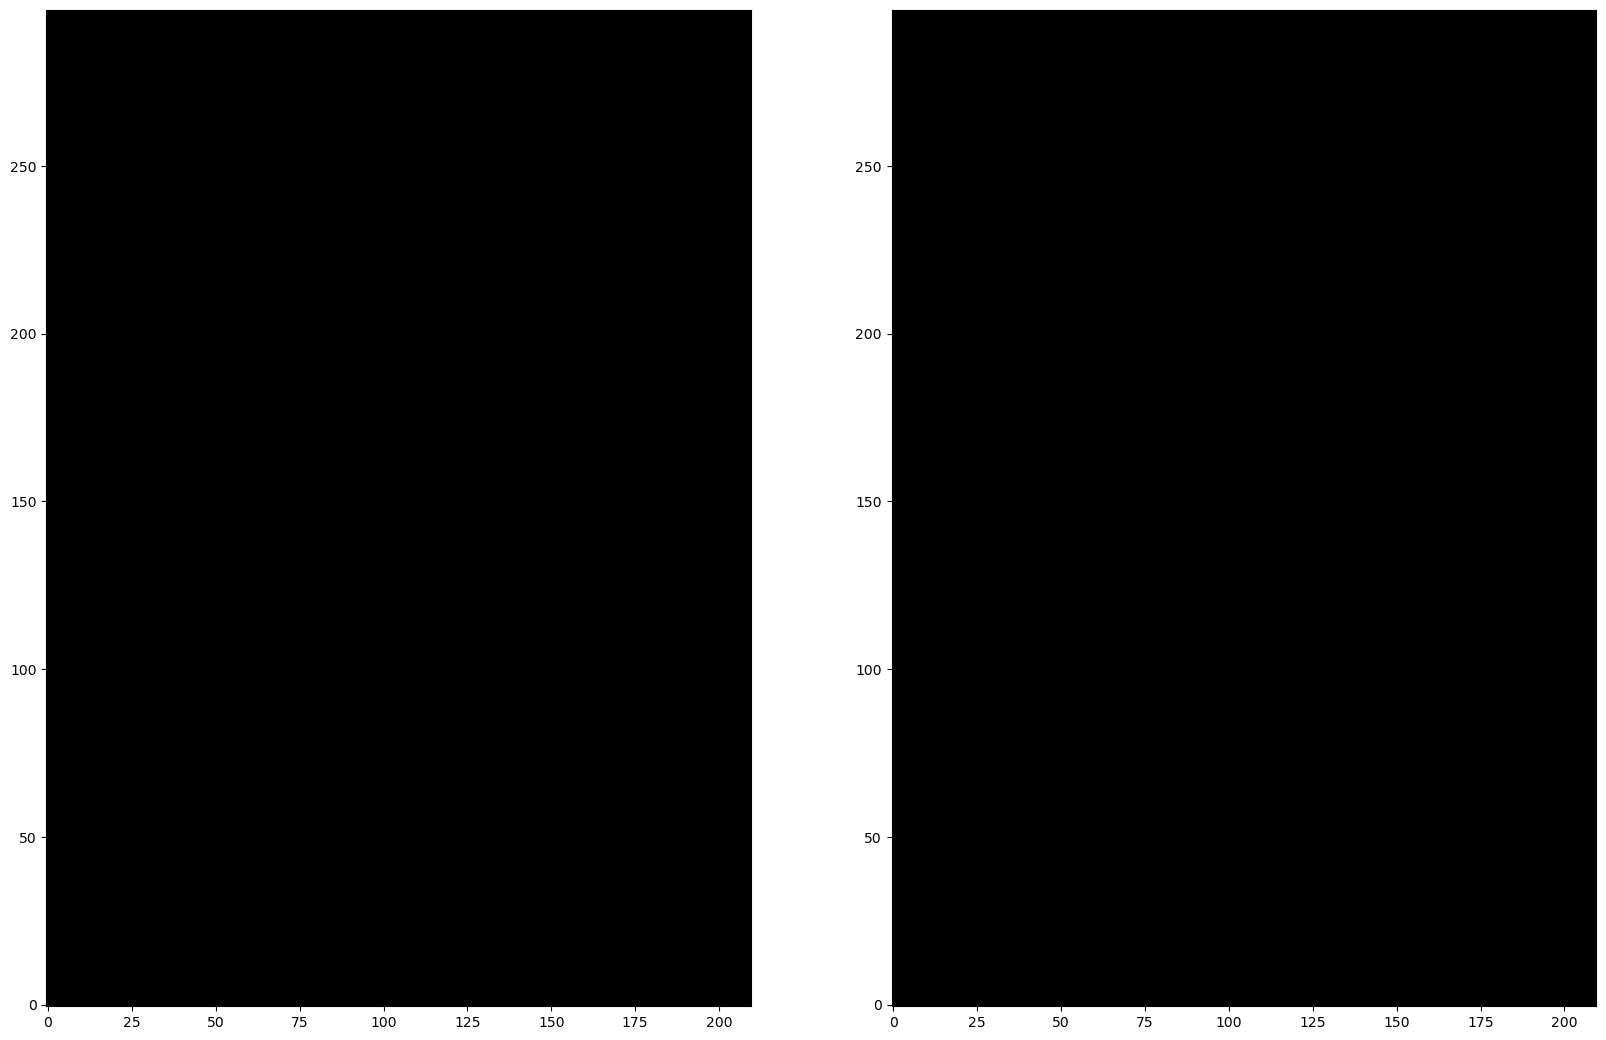

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))  # 1행 2열
im1 = axes[0].imshow(np.zeros(RESOLUTION), cmap='gray', vmin=0, vmax=1, origin="lower")
im2 = axes[1].imshow(np.zeros(RESOLUTION), cmap='gray', vmin=0, vmax=1, origin="lower")

line_segments1 = LineCollection([], colors='gray', linewidths=0.5)

axes[1].add_collection(line_segments1)

inflow_h_mask = (inflow_heat == 0)
inflow_d_mask = (inflow_dye == 0)

points = np.array([[p, 6] for p in np.linspace(middle - offset, middle + offset, num_polyline)]) 
arr = np.tile(points[:, None, :], (1, num_points, 1))
polylines = torch.tensor(arr, dtype=torch.float32, device="cuda")# (num_polylines, num_points, 2)

t = 0

def update(frame):
    global t, polylines, inflow_h_mask, inflow_d_mask

    for i in range(int(FRAME_DT / DT)):
        if t <= INFLOW_DURATION:
            fluid.heat = torch.where(inflow_h_mask, fluid.heat, inflow_heat)
            fluid.dye = torch.where(inflow_d_mask, fluid.dye, inflow_dye)
            
        ambient = torch.mean(fluid.heat)  # 혹은 상수 0
        dT = fluid.heat - ambient
        dv = buoyancy_a * dT * DT
        fluid.velocity[1] += dv
        
        # 열 에너지 소모 (운동에너지로 전환)
        dEk = 0.5 * dv**2   # pointwise kinetic energy 증가
        fluid.heat = torch.clamp(fluid.heat - dEk, min=0.0)
        fluid.step(dt=DT, eps_conf=0.04)
    
        
        polylines[:, 1:, :] = advect_polylines(fluid.velocity, polylines[:, 1:, :], DT)
        polylines = redistribute_polyline_points(polylines)
        t += DT

    dye_cpu = fluid.dye.cpu().numpy()
    dye_cpu[dye_cpu >= 1] = 1
    frame1 = dye_cpu

    im1.set_data(frame1)

    drawing_polylines = get_drawing_polylines(polylines)
    line_segments1.set_segments(drawing_polylines)
    
    clear_output(wait=True)
    display(fig)
    height, width = RESOLUTION  # 이미지 크기
    if not hasattr(update, "time_text"):
        update.time_text = axes[1].text(
            width - 5, 5,  # x=가로 끝-여유, y=밑에서 약간 위
            "", color="white", fontsize=12,
            ha="right", va="bottom", backgroundcolor="black"
        )
    
    update.time_text.set_text(f"{t:.2f} / {TOTAL_T}")

    return im1, im2, line_segments1



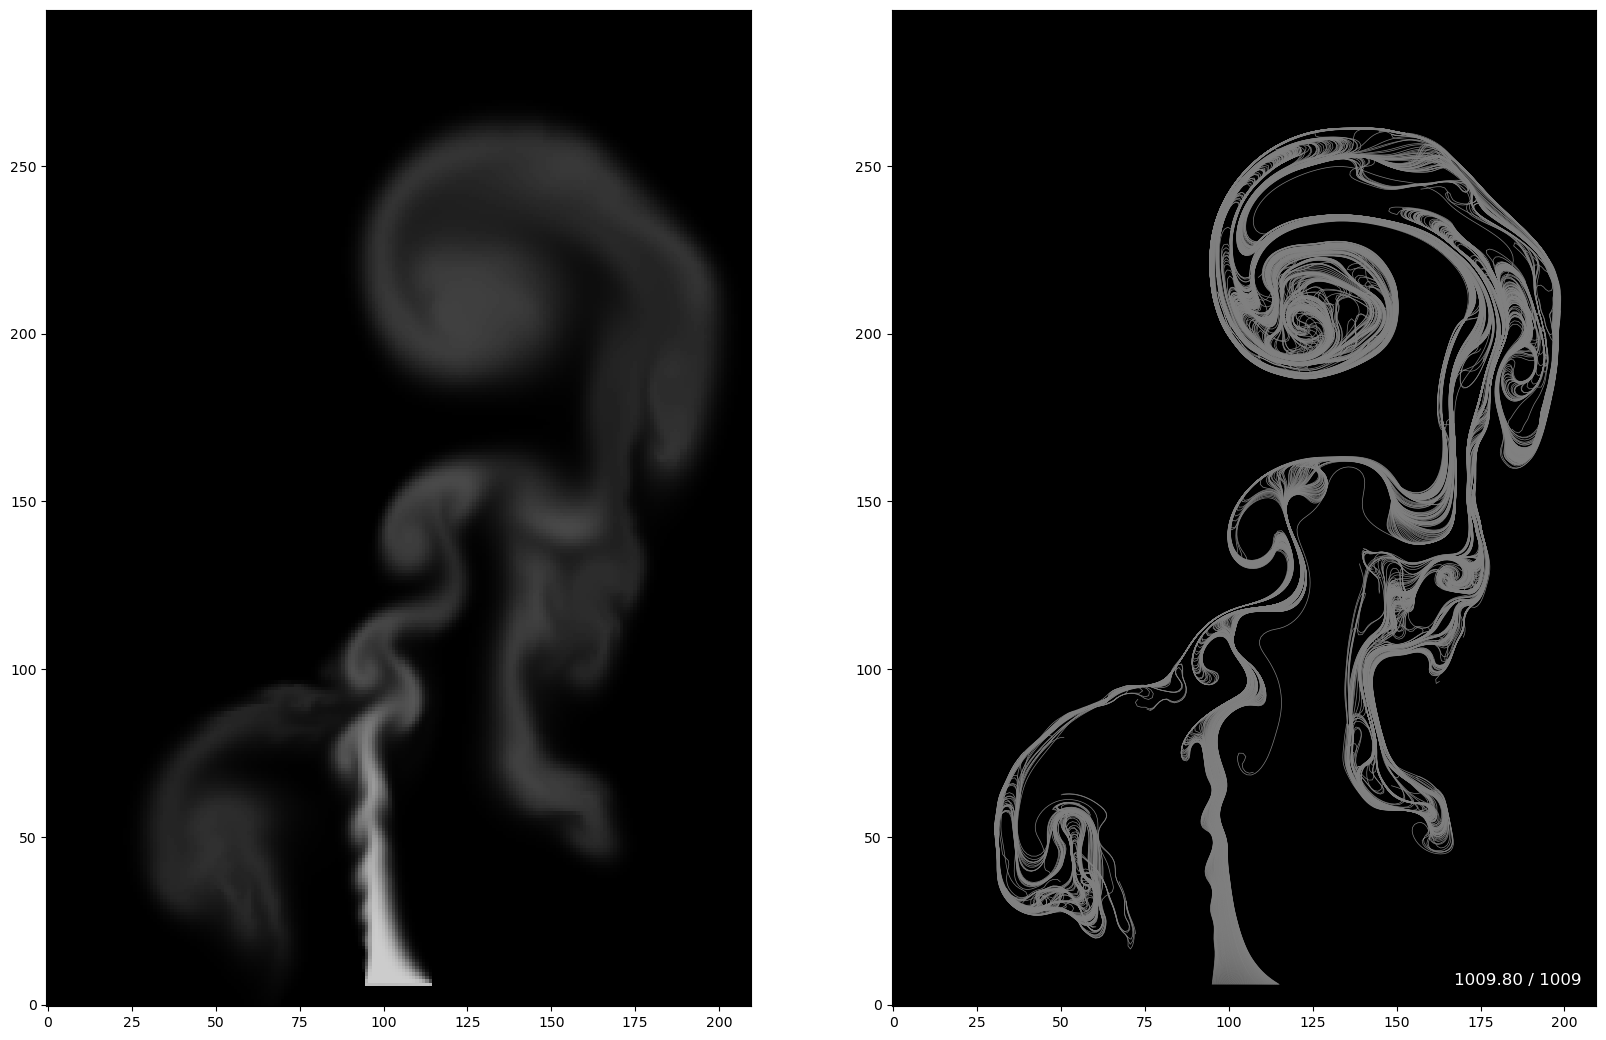

In [7]:
ani = animation.FuncAnimation(fig, update, frames=int(TOTAL_T / FRAME_DT), interval=50, blit=True)

# mp4 저장 (ffmpeg 필요)
ani.save("output.mp4", writer=animation.FFMpegWriter(fps=20))

In [8]:
torch.save(polylines, 'polyline.pt')